<h1 align=center> Course Project: An Arbitrage-Free Smile Interpolator</h1>

*Project report should be submitted as a Jupyter notebook (.ipynb). The report should be written based on this notebook. Please make your formulas and code, test results, observations, intermediate results, improvements made/suggested (optional), and conclusions clear.*

#### Objectives
  - Implement an arbitrage free smile interpolator SmileAF.
  - Use the arbitrage free smile interpolator to construct local volatility model
  - Use PDE with local volatility model to price a given set of European options (strike in delta $\times$ maturity)
  - Compare the price errors of arbitrage-free smile interpolator and the cubic spline smile interpolator
  - Open questions for bonus points: improve the algorithms in terms of precision and efficiency (smile interpolation, implied vol, local vol, PDE, calibration report). One area to consider for improvement is the construction of the tails (wings).

##### Smile Arbitrage
1. European call prices are monotonically decreasing with respect to the strike:

    \begin{align}
    C(S_0, K_1, T, \sigma(K_1), r, q) \geq C(S_0, K_2, T, \sigma(K_2), r, q) ~\text{for}~K_1 < K_2
    \end{align}


2. The European call price as a function of strike has to be convex every where: for any three points $K_1 < K_2 < K_3$

    \begin{align}
    \frac{C(K_2) - C(K_1) } {K_2 - K_1} < \frac{C(K_3) - C(K_2) } {K_3 - K_2}
    \end{align}

    or

    \begin{align}
    C(K_2)  < C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1}
    \end{align}

    This is also equivalent to "butterfly price has to be non-negative".

##### When Could Smile Arbitrage Happen?

The undiscounted call price is the expectation of payoff under risk neutral measure

\begin{align}
C(K) = E[\max(S-K, 0)]
\end{align}

And expectation is an integral over the probability density function $p(s)$

\begin{align}
C(K) = \int_{K}^{+\infty} (s-K) p(s) ds
\end{align}

The 1st non-arbitrage condition translates to

\begin{align}
& C(K_1) - C(K_2) = \left[ \int_{K_1}^{K_2} (s-K_1) p(s) ds  + \int_{K_2}^{+\infty} (K_2-K_1) p(s) ds \right]
\end{align}

which is positive by definition if $K_2 > K_1$.

The 2nd non-arbitrage condition translates to

\begin{align}
& C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1} - C(K_2) \\
= & \frac{K_3-K_2} {K_3 - K_1} \int_{K_1}^{K_2} (s-K_1) p(s) ds + \frac{K_2 - K_1} {K_3 - K_1} \int_{K_2}^{K_3} (K_3 - s) p(s) ds
\end{align}

which is also positive by definition if $K_3 > K_2 > K_1$.

So, when could smile arbitrage happen? **When the probability density does not exist**. If we can start with valid probability density function $p(s)$, arbitrage-freeness is guaranteed by construction.


#### Arbitrage Free Smile (Based on [Fengler 2009])

- We consider smile construction for a given expiry $T$.
- Start with $N$ discrete sample strike points

    \begin{align*}
    \vec{k} = [k_1, k_2, \ldots, k_{N}]^{\top}
    \end{align*}

- Try to solve for undiscounted call prices for these $N$ sample points

    \begin{align*}
    \vec{c} = [c_1, c_2, \ldots, c_N]^{\top}
    \end{align*}

- For the undiscounted call price $C(K)$ for any $K$, we can interpolate using cubic spline over the sample points $(k_i, c_i)$. (Note that we are using cubic spline to interpolate the prices, not volatility)

- The second derivative of call price with respect to strike is the probability density function:

    \begin{align}
    \frac{d C}{d K} & =  d \frac{\int_K^{\infty} Sp(S) dS}{dK} - d \frac{K\int_K^{\infty} p(S) dS}{dK} = -Kp(K) - \left( \int_K^{\infty} p(S) dS - K p(K)\right) = -\int_K^{\infty} p(S) dS \\
    \frac{d^2 C}{d K^2} & = p(K)
    \end{align}

  So $c_i''$ is probability density function at $k_i$, we denote it as $p_i$

- Second derivatives in cubic spline interpolation form line segments. Cubic spline on $C(K)$, means linearly interpolate on probability density. If $p_i$ are all positive, the whole pdf is positive by construction --- **no smile arbitrage**.

- For tails --- call prices are almost linear if strike is very far away from spot, we can use **natural cubic spline**: $p_1 = p_N = 0$.

- Our problem is to solve for $[c_1, c_2, \ldots, c_{N}, p_2, \ldots, p_{N-1}]$

#### Inputs to our problem

Same as our Cubic Spline smile interpolator, we have the input marks to start with to construct the Arb-Free(AF) smile interpolator:

 - **Marks**:  strike to volatility pairs, denote as $(\hat k_j, \sigma_j)$, for $j \in [1, 2, \ldots, M]$. In our case, $M=5$.

We would like to match the marks exactly. And we cannot directly construct a cubic spline using the $M$ points --- too coarse and distribution is not realistic.

#### Problem Definition
- We use $N = 50$ sample points, ranging from $[k_1 = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T - 5 \sigma_{ATM} \sqrt{T}}, k_N = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T + 5 \sigma_{ATM} \sqrt{T} }]$, i.e., $\pm 5$ standard deviation based on $\sigma_{ATM}$.
- $\sigma_{ATM}$ is implied volatility of the middle point of the input marks.
- We also assume the strike of the middle point of the input marks is the forward --- ATM forward convention.
- The sample points are equally spaced, denote the length of the segment $u = \frac{k_N - k_1}{N-1}$
- We would like the call prices to be as smooth as possible --- minimize the change of the slopes
- We want to match exactly the $M$ input marks.
- This is a constrained optimization problem.

 **Constraints**
 - Cubic spline interpolation imposes the constraints that the left and right first derivative of a point have to match, it can be derived by matching the first  derivative of the left and right segments for point $i$ we have the condition

   \begin{align}
   c_{i+1} + c_{i-1} - 2 c_{i} = (\frac23 p_i + \frac16 p_{i+1} + \frac16 p_{i-1}) u^2
   \end{align}

   The cubic spline constraints translate to the linear system

   \begin{align} \underbrace{\begin{pmatrix}
   1 & -2 & 1 & 0 & \ldots & 0 \\
   0 & 1 & -2 & 1 & \ddots & \vdots \\
   \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
   0 & \ldots & 0 & 1 & -2 & 1
   \end{pmatrix}}_{\vec{Q}_{(N-2) \times N}}
   \begin{pmatrix}
   c_1 \\
   c_2 \\
   \vdots \\
   c_N
   \end{pmatrix} =
   \underbrace{u^2
   \begin{pmatrix}
   \frac23 & \frac16 & 0 & \ldots & 0 \\
   \frac16 & \frac23 & \frac16 & \ddots & \vdots \\
   0 & \ddots & \ddots & \ddots & 0 \\
   \vdots & \ddots & \frac 1 6 & \frac23 & \frac16 \\
   0 & \ldots & 0 & \frac 1 6 &  \frac23
   \end{pmatrix}}_{\vec{R}_{(N-2) \times (N-2)}}
   \begin{pmatrix}
   p_2 \\
   p_3 \\
   \vdots \\
   p_{N-1}
   \end{pmatrix}
   \end{align}

   If we define
   \begin{align}
   \vec{x} =
   \begin{pmatrix}
   \vec{c}^{\top} \\
   \vec{p}^{\top} \\
   \end{pmatrix}, ~~~
   \vec{A} = (\vec{Q}, -\vec{R})
   \end{align}

   we can represent the constraint as:
   \begin{align}
   \vec{Ax} = \vec{0} ~~~\textbf{   Constraint 1}
   \end{align}

 - The call prices at the input marks $\hat k_j, j \in [1, 2, \ldots, M]$ can be represented by cubic spline interpolation
   \begin{align}
   C(\hat k_j) =  a c_i + b c_{i+1} + \frac{(a^3 - a)u^2}6 p_i + \frac{(b^3-b) u^2}6 p_{i+1} ~~~\textbf{--- Constraint 2}
   \end{align}

   where

   \begin{align}
   a = \frac{k_{i+1} - \hat k_j}{u},~~~b = 1-a
   \end{align}

   and $[k_i, k_{i+1}]$ here represents the segment that $\hat k_j$ falls in.

 - $p_i$ are densities, so

    \begin{align}
    p_i > 0 ~~~\textbf{--- Constraint 3}
    \end{align}

 - Integrating the density function we should get 1.0 (recall that density function are linearly interpolated)

    \begin{align}
    u \sum p_i = 1.0 ~~~\textbf{--- Constraint 4}
    \end{align}

 - Natural cubic spline, $p_1$ and $p_N$ are zero, so we could solve directly $c_1$ and $c_N$

    \begin{align}
    c_1 = Se^{(r_d - r_f)T} - k_1, ~~~c_N = 0  ~~~\textbf{--- Constraint 5}
    \end{align}

 - Call prices are monotonically decreasing:

    \begin{align}
    c_{i+1} - c_{i} \leq 0 ~~~\text{for}~i \in \{1, 2, \ldots, N-1\}  ~~~\textbf{--- Constraint 6}
    \end{align}


 **Objective Function**

 - Fill the rest of the DOF using objective function (soft constraints)

 - [Fengler 2009] tried minimizing the below to achieve smoothness on $p$:

    \begin{align}
    \int_{k_1}^{k_N} p(S)^2 dS = \text{constant} \times \vec{p}^{\top} \vec{R} \vec{p}
    \end{align}

    Using $\vec{x}$ as variable and define

    \begin{align}
    \vec{H}_{(2N-2) \times (2N-2)} =
    \begin{pmatrix}
    \vec{0} & \vec{0} \\
    \vec{0} & \vec{R}_{(N-2) \times (N-2)}
    \end{pmatrix}
    \end{align}

    the problem becomes minimizing

    \begin{align}
    \vec{x}^\top \vec{H} \vec{x}
    \end{align}

**Problem Formulation**

 We can formulate our problem as
    \begin{align}
    \min~~~\vec{x}^\top \vec{H} \vec{x}
    \end{align}
 subject to constraints 1 to 5.
 - All the constraints are linear function of $\vec{x}$
 - Our objective function is quadratic and the matrix $\vec{H}$ is positive semi-definite
 - Global solution exists, and (relatively) efficient to solve

**Tips**
 - To solve the quadratic programming problem, we can use the CVXOPT package:
   - http://cvxopt.org/examples/tutorial/qp.html
   - https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
 - Write down the exact formulas using the same symbols used by CVXOPT QP problem's documentation in the above docs, then translate them into code. This will make debugging easier.
 - To check whether solver's result makes sense, examine if the constraints are satisified, and if the call prices are smooth and match the input.
 - If test run takes too long, reduce the number of grid points in PDE pricer, or skip the calibration report and inspect the volatility surface first.
 - It might be easier to plot implied vol, call prices, PDF, and the marks to check the result.
 - use bisect.bisect_left to find the bucket $\hat{k}$ belongs to (https://docs.python.org/3/library/bisect.html)

**References**

[Fengler 2009] Arbitrage-free smoothing of the implied volatility surface, Quantitative Finance, 2009

***
### Implementation

**It will take around 20 minutes to run the whole file.**

$Ax = b$ is written as: (Equality Constraints)

\begin{align}
\overbrace{\begin{pmatrix}
\overbrace{\begin{pmatrix}
   1 & -2 & 1 & 0 & \ldots & 0 \\
   0 & 1 & -2 & 1 & \ddots & \vdots \\
   \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
   0 & \ldots & 0 & 1 & -2 & 1
\end{pmatrix}}^{\mathbf{Q}_{(N-2) \times N}}
\overbrace{\begin{pmatrix}
   -u^2\frac23 & -u^2\frac16 & 0 & \ldots & 0 \\
   -u^2\frac16 & -u^2\frac23 & -u^2\frac16 & \ddots & \vdots \\
   0 & \ddots & \ddots & \ddots & 0 \\
   \vdots & \ddots & -u^2\frac16 & -u^2\frac23 & -u^2\frac16 \\
   0 & \ldots & 0 & -u^2\frac16 &  -u^2\frac23
\end{pmatrix}}^{-\mathbf{R}_{(N-2) \times (N-2)}}\\
\begin{pmatrix}
\ldots & \ldots & \overbrace{a}^{\text{pos}= \text{index}_i} & \overbrace{b}^{\text{pos}=\text{index}_i+1} & \ldots & \ldots & \overbrace{\frac{(a^3-a)u^2}{6}}^{\text{pos}=\text{index}_i+N-1} & \overbrace{\frac{(b^3-b)u^2}{6}}^{\text{pos}=\text{index}_i+N} & \ldots & \ldots
\end{pmatrix}_{{M \times (2N-2)}}\\
\begin{pmatrix}
0 & 0 & \ldots & \ldots & \ldots & 0
\end{pmatrix}_{{1 \times N}}
\begin{pmatrix}
1 & 1 & \ldots & \ldots & \ldots & 1
\end{pmatrix}_{{1 \times (N-2)}}\\
\begin{pmatrix}
1 & 0 & \ldots & \ldots & \ldots & 0\\
0 & 0 & \ldots & 0 & \ldots & 1 
\end{pmatrix}_{{2 \times N}}
\begin{pmatrix}
0 & 0 & \ldots & \ldots & \ldots & 0\\
0 & 0 & \ldots & 0 & \ldots & 0 
\end{pmatrix}_{{2 \times (N-2)}}
\end{pmatrix}}^{{A}}
\overbrace{\begin{pmatrix}
  c_1 \\
  c_2 \\
  \vdots \\
  c_N\\
  p_2\\
  p_3\\
  \vdots\\
  p_{N-1}
  \end{pmatrix}}^{{x}} = 
 \overbrace{\begin{pmatrix}
 0\\
 \vdots\\
 \vdots\\
 \vdots\\
 0\\
 C(\hat{k_i}),i = 1,\dots,M\\
 \frac{1}{u}\\
S*\mathrm{e}^{(r_d-r_f)T}-k_1\\
0
\end{pmatrix}}^{b}
\end{align}

$Gx \le h$ is written as: (Inequality Constraints)

\begin{align}
\overbrace{\begin{pmatrix}\begin{matrix}\boldsymbol 0\end{matrix}_{{(N-2) \times N}}
&\begin{matrix}\mathbf{-I}\end{matrix}_{{(N-2) \times (N-2)}}\\
\begin{pmatrix}
-1 & 1 & 0 & \ldots & \ldots & 0\\
0 & -1 & 1 & 0 & \ldots & 0\\
\vdots & \ddots & \ddots & \ddots & \ddots &\vdots\\
0 & \ldots & \ldots & 0 & -1 & 1 
\end{pmatrix}_{{(N-1) \times N}}&\mathbf{0}_{{(N-1) \times (N-2)}}\end{pmatrix}}^{{G}}
   \begin{pmatrix}
   c_1 \\
   c_2 \\
   \vdots \\
   c_N\\
   p_2\\
   p_3\\
   \vdots\\
   p_{N-1}
   \end{pmatrix} \le
   \overbrace{\begin{pmatrix}-\epsilon\\ -\epsilon \\ \vdots \\ -\epsilon \\ 0 \\ 0\\ \vdots \\0\end{pmatrix}}^{{h}}.
\end{align}
Here, we set $\epsilon = 10^{-20}$.

Therefore, the standard form of the optimal problem is shown as
\begin{align}
\text{min: } \frac{1}{2}x^TPx+q^Tx
\end{align}
subject to 
\begin{align}
\begin{cases}
Gx \le h \\
Ax = b,
\end{cases}
\end{align}
where
\begin{align}
P_{(2N-2) \times (2N-2)} =
\begin{pmatrix}
\vec{\mathbf{0}} & \vec{\mathbf{0}} \\
\vec{\mathbf{0}} & 2\mathbf{R}_{(N-2) \times (N-2)}
\end{pmatrix},
q^T = \vec{\mathbf{0}}_{1 \times (2N-2)}.
\end{align}

Below are some building blocks for the project. You contribution should be in SmileAF class.
You can modify any other classes or methods. If you do so, please describe your modification in the project report.

In [1]:
import math
import numpy as np
from enum import Enum
from scipy import optimize
import bisect
from scipy.interpolate import CubicSpline

class PayoffType(Enum):
    Call = 0
    Put = 1

def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return - cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

# solve for the K such that Delta(S, T, K, vol) = delta
def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    fwd = S * math.exp((r-q) * T)
    if payoffType == PayoffType.Put:
        delta = -delta
    f = lambda K: (fwdDelta(fwd, vol * math.sqrt(T), K, payoffType) - delta)
    a, b = 0.0001, 10000
    return optimize.brentq(f, a, b)

class ImpliedVol:
    def __init__(self, ts, smiles):  #time sequence
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return

    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.001) - self.Vol(t, k-0.001)) / 0.002
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.001) + self.Vol(t, k-0.001) - 2*self.Vol(t, k)) / 0.000001

class LocalVol:
    def __init__(self, iv, S0, rd, rf):
        self.iv = iv
        self.S0 = S0
        self.rd = rd
        self.rf = rf
    def LV(self, t, s):
        if t < 1e-6:
            return self.iv.Vol(t, s)
        imp = self.iv.Vol(t, s)
        dvdk = self.iv.dVoldK(t, s)
        dvdt = self.iv.dVoldT(t, s)
        d2vdk2 = self.iv.dVol2dK2(t, s)
        d1 = (math.log(self.S0/s) + (self.rd-self.rf)*t + imp * imp * t / 2) / imp / math.sqrt(t)
        numerator = imp*imp + 2*t*imp*dvdt + 2*(self.rd-self.rf)*s*t*imp*dvdk
        denominator = (1+s*d1*math.sqrt(t)*dvdk)**2 + s*s*t*imp*(d2vdk2 - d1 * math.sqrt(t) * dvdk * dvdk)
        localvar = min(max(numerator / denominator, 1e-8), 1.0)
        if numerator < 0: # floor local volatility
            localvar = 1e-8
        if denominator < 0: # cap local volatility
            localvar = 1.0
        return math.sqrt(localvar)

class EuropeanOption():
    def __init__(self, assetName, expiry, strike, payoffType):
        self.assetName = assetName
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

# Black-Scholes analytic pricer
def bsPrice(S, r, q, vol, T, strike, payoffType):
    fwd = S * math.exp((r-q) * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    else:
        raise Exception("not supported payoff type", payoffType)

#Undiscounted BS Price
def bsPrice2(fwd, vol, T, strike, payoffType):  
    #fwd = S * math.exp((r-q) * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return fwd * cnorm(d1) - cnorm(d2) * strike
    elif payoffType == PayoffType.Put:
        return strike * cnorm(-d2) - cnorm(-d1) * fwd
    else:
        raise Exception("not supported payoff type", payoffType)

# PDE pricer with local volatility
def pdePricerX(S0, r, q, lv, NX, NT, w, trade):
    # set up pde grid
    mu = r - q
    T = trade.expiry
    X0 = math.log(S0)
    vol0 = lv.LV(0, S0)
    srange = 5 * vol0 * math.sqrt(T)
    maxX = X0 + (mu - vol0 * vol0 * 0.5)*T + srange
    minX = X0 - (mu - vol0 * vol0 * 0.5)*T - srange
    dt = T / (NT-1)
    dx = (maxX - minX) / (NX-1)
    # set up spot grid
    xGrid = np.array([minX + i*dx for i in range(NX)])
    # initialize the payoff
    ps = np.array([trade.payoff(math.exp(x)) for x in xGrid])
    # backward induction
    for j in range(1, NT):
        # set up the matrix, for LV we need to update it for each iteration
        M = np.zeros((NX, NX))
        D = np.zeros((NX, NX))
        for i in range(1, NX - 1):
            vol = lv.LV(j*dt, math.exp(xGrid[i]))
            M[i, i - 1] = (mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            M[i, i] = r + vol * vol / dx / dx
            M[i, i + 1] = -(mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            D[i, i] = 1.0
        # the first row and last row depends on the boundary condition
        M[0, 0], M[NX - 1, NX - 1] = 1.0, 1.0
        rhsM = (D - dt * M) * w + (1 - w) * np.identity(NX)
        lhsM = w * np.identity(NX) + (D + dt * M) * (1 - w)
        inv = np.linalg.inv(lhsM)

        ps = rhsM.dot(ps)
        ps[0] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[0])) # discounted payoff
        ps[NX-1] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[NX-1]))
        ps = inv.dot(ps)
    # linear interpolate the price at S0
    return np.interp(X0, xGrid, ps)

Below are the smile interpolators and smile constructor. You need to implement SmileAF. Note that smileFromMarks takes a parameter smileInterpMethod. When it is 'AF', SmileAF is used.

In [2]:
from cvxopt import matrix
from cvxopt import solvers

In [3]:
class SmileAF:
    def __init__(self, strikes, vols, T):
        self.atmvol = vols[int(len(vols)/2)]
        self.fwd = strikes[int(len(strikes)/2)]
        self.T = T
        self.N = 50 #number of sample points
        stdev = self.atmvol * math.sqrt(T)
        kmin = self.fwd * math.exp(-0.5*stdev*stdev-5 * stdev)
        kmax = self.fwd * math.exp(-0.5*stdev*stdev+5 * stdev)
        u = (kmax - kmin) / (self.N - 1)
        self.ks = [kmin + u * i for i in range(0, self.N)]
        self.cs = np.zeros(self.N)  # undiscounted call option prices
        self.ps = np.zeros(self.N)  # densities
        self.u = u
        
        # now we need to construct our constrained optimization problem to solve for cs and ps
        #Your code here to solve for self.cs and self.ps
        
        # Equality Constraints
        R = np.zeros((self.N-2,self.N-2))
        P = np.zeros((2*self.N-2,2*self.N-2)) 
        Q = np.zeros((self.N-2,self.N))
        for i in range(1,self.N-3):
            R[i,i] = 2/3*self.u**2
            R[i,i-1] = 1/6*self.u**2
            R[i,i+1] = 1/6*self.u**2
        R[0,0],R[self.N-3,self.N-3] = 2/3*self.u**2,2/3*self.u**2
        R[0,1],R[self.N-3,self.N-4] = 1/6*self.u**2,1/6*self.u**2
        for i in range(self.N-2):
            Q[i,i] = 1
            Q[i,i+1] = -2
            Q[i,i+2] = 1
        A1 = np.hstack((Q,-R))  #constraint 1
        indices = [bisect.bisect_left(self.ks, strike) for strike in strikes]
        A2 = np.zeros((len(strikes),2*self.N-2))
        for index,i in zip(indices,range(len(strikes))):
            a = (self.ks[index+1]-strikes[i])/self.u
            b = 1-a
            #constraint 2
            A2[i,index],A2[i,index+1] = a,b  
            A2[i,index+self.N-1],A2[i,index+self.N] = (a*a*a-a)*self.u**2/6,(b*b*b-b)*self.u**2/6
        A3 = np.concatenate((np.zeros(self.N),np.ones(self.N-2)),axis = 0)  #constraint 4
        #constraint 5
        A4 = np.zeros((2,2*self.N-2)) 
        A4[0,0],A4[1,self.N-1] = 1,1
        A = matrix(np.vstack((A1,A2,A3,A4)))
        b = matrix(np.concatenate((np.zeros(self.N-2),[bsPrice2(self.fwd, vol, self.T, strike, PayoffType.Call) for vol,strike in zip(vols,strikes)],[1/u],[self.fwd-kmin,0]),axis = 0)) #self.Price(strike) 
       
        #Inequality Constraints
        G1 = np.hstack((np.zeros((self.N-2,self.N)),-np.identity(self.N-2))) #constraint 3
        G2 = np.zeros((self.N-1,2*self.N-2))
        for i in range(self.N-1):
            G2[i,i],G2[i,i+1] = -1,1  #constraint 6
        G = matrix(np.vstack((G1,G2)))
        h = matrix(np.concatenate((np.ones(self.N-2)*(-1e-20),np.zeros(self.N-1))))
#         G/=1e-08
#         h/=1e-08
        
        # Standard form
        for i in range(self.N,2*self.N-2):
            for j in range(self.N,2*self.N-2):
                P[i,j] = 2*R[i-self.N,j-self.N]
        P = matrix(P)
        q = matrix(np.zeros(2*self.N-2)) 
        
        self.A = A
        self.b = b
        self.G = G
        self.H = h
        self.P = P
        self.q = q
        
        # Construct the QP, invoke solver
        sol = solvers.qp(P,q,G,h,A,b)
        # Extract optimal value and solution
        for i in range(self.N):
            self.cs[i] = sol['x'][i]
        for i in range(self.N-2):
            self.ps[i+1] = sol['x'][i+self.N] 
        self.optimal = sol['primal objective']
        
        # now we obtained cs and ps, we do not interpolate for price for any k and imply the vol,
        # since at the tails the price to vol gradient is too low and is numerically not stable.
        # Instead, we imply the volatilities for all points between put 10 delta and call 10 delta input points
        # then we make the vol flat at the wings by setting the vols at kmin and kmax,
        # we then construct a cubic spline interpolator on the dense set of volatilities so that it's C2
        # and faster then implying volatilities on the fly.
        # note that this treatment of tail is simplified. It could also introduce arbitrage.
        # In practice, the tails should be calibrated to a certain distribution.
        def implyVol(k, prc, v): #root searcher
            stdev = v * math.sqrt(self.T)
            d1 = (math.log(self.fwd / k)) / stdev + 0.5 * stdev
            d2 = (math.log(self.fwd / k)) / stdev - 0.5 * stdev
            return self.fwd * cnorm(d1) - k * cnorm(d2) - prc
        khmin = bisect.bisect_left(self.ks, strikes[0])
        khmax = bisect.bisect_right(self.ks, strikes[len(strikes)-1])
        kks = [0] * ((khmax+1) - (khmin-1) + 2)
        vs = [0] * ((khmax+1) - (khmin-1) + 2)
        for i in range(khmin-1, khmax+1):
            prc = self.Price(self.ks[i])
            f = lambda v: implyVol(self.ks[i], prc, v)
            a, b = 1e-8, 10
            vs[i - (khmin-1) + 1] = optimize.brentq(f, a, b) #bisectalgorithm(f,a,b,1e-6)  #root search
            kks[i - (khmin-1) + 1] = self.ks[i]
        kks[0] = kmin
        vs[0] = vs[1]
        kks[len(kks)-1] = kmax
        vs[len(vs)-1] = vs[len(vs)-2]

        self.vs = vs
        self.cubicVol = CubicSpline(kks, vs, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

    def Vol(self, k):
        if k < self.ks[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vs[0]
        if k > self.ks[-1]:
            return self.vs[-1]
        else:
            return self.cubicVol(k)

    # undiscounted call price - given cs and ps,
    # we can obtain undiscounted call price for any k via cubic spline interpolation
    def Price(self, k):
        if k <= self.ks[0]:
            return self.fwd - k
        if k >= self.ks[self.N-1]:
            return 0.0
        pos = bisect.bisect_left(self.ks, k)
        a = (self.ks[pos] - k) / self.u
        b = 1 - a
        c = (a * a * a - a) * self.u * self.u / 6.0
        d = (b * b * b - b) * self.u * self.u / 6.0
        return a * self.cs[pos-1] + b * self.cs[pos] + c*self.ps[pos-1] + d*self.ps[pos]
        
class SmileCubicSpline:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes + [1.1 * strikes[-1] - 0.1 * strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1] - vols[-2]) / 10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10, smileInterpMethod):
    c25 = bf25 + atmvol + rr25/2
    p25 = bf25 + atmvol - rr25/2
    c10 = bf10 + atmvol + rr10/2
    p10 = bf10 + atmvol - rr10/2

    ks = [ strikeFromDelta(S, r, q, T, p10, 0.1, PayoffType.Put),
           strikeFromDelta(S, r, q, T, p25, 0.25, PayoffType.Put),
           S * math.exp((r-q)*T),
           strikeFromDelta(S, r, q, T, c25, 0.25, PayoffType.Call),
           strikeFromDelta(S, r, q, T, c10, 0.1, PayoffType.Call) ]
    # print(T, ks)
    if smileInterpMethod == "CUBICSPLINE":
        return SmileCubicSpline(ks, [p10, p25, atmvol, c25, c10])  #strikes, vols
    elif smileInterpMethod == "AF":
        return SmileAF(ks, [p10, p25, atmvol, c25, c10], T)  #strikes, vols, T
    elif smileInterpMethod == "AF_Imp":
        return SmileAF_Imp(ks, [p10, p25, atmvol, c25, c10], T)

Below is a calibration report that shows the calibration error of local volatility PDE pricer.

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def createTestFlatVol(S, r, q, smileInterpMethod):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]  #T
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = np.zeros(len(atmvols))
    rr25s = np.zeros(len(atmvols))
    bf10s = np.zeros(len(atmvols))
    rr10s = np.zeros(len(atmvols))
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i], smileInterpMethod) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def createTestImpliedVol(S, r, q, sc, smileInterpMethod):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]  #T
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i]*sc, rr25s[i]*sc, bf10s[i]*sc, rr10s[i]*sc, smileInterpMethod) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles),smiles

def plotTestImpliedVolSurface(iv):
    tStart, tEnd = 0.02, 5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Put)  #delta = 0.1
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Call)
    ks = np.arange(kmin, kmax, 0.01)
    vs = np.ndarray((len(ts), len(ks)))
    lv = LocalVol(iv, S, r, q)
    lvs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])  #implied vol
            lvs[i, j] = lv.LV(ts[i], ks[j])  #local vol
    hf = plt.figure(figsize=(8, 6), dpi=80)
    ha = hf.add_subplot(121, projection='3d')
    hb = hf.add_subplot(122, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    ha.set_title("implied vol")
    ha.set_xlabel("strike")
    ha.set_ylabel("T")
    hb.plot_surface(X, Y, lvs)
    hb.set_title("local vol")
    hb.set_xlabel("strike")
    hb.set_ylabel("T")
    plt.show()

#Plot the implied volatility smile(cross-sectional), given the pillar points
def plotTestImpliedVol(iv):
    tEnd = 5
    ts = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]  #Test pillar pointsz
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Put)  #delta = 0.1
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Call)
    ks = np.arange(kmin, kmax, 0.01)
    vs = np.ndarray((len(ts), len(ks)))
    lv = LocalVol(iv, S, r, q)
    lvs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])  #implied vol
            lvs[i, j] = lv.LV(ts[i], ks[j])  #local vol
    hf = plt.figure(figsize=(15,10), dpi=80)
    ha = hf.add_subplot(121)
    hb = hf.add_subplot(122)
    for i in range(len(ts)):
        ha.plot(ks,vs[i,:])
    ha.set_title("implied vol")
    ha.set_xlabel("strike")
    ha.set_ylabel("vol")
    for i in range(len(ts)):
        hb.plot(ks,lvs[i,:])
    hb.set_title("local vol")
    hb.set_xlabel("strike")
    hb.set_ylabel("vol")
    plt.show()

# the PDE calibration error report takes an implied volatility surface,
# verifies the pricing error of the pde pricer with local volatility surface
def pdeCalibReport(S0, r, q, impliedVol):
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]  #time
    ds = np.arange(0.1, 1.0, 0.1)  #delta
    # ds = np.arange(0.5, 1.7, 0.1)
    err = np.zeros((len(ds), len(ts)))
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_xlabel("T")
    ax.set_yticks(np.arange(len(ds)))
    ax.set_ylabel("Put Delta")
    ax.set_xticklabels(map(lambda t : round(t, 2), ts))
    ax.set_yticklabels(map(lambda d : round(d, 1), ds))

    # create local vol surface
    lv = LocalVol(impliedVol, S0, r, q)
    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            T = ts[j]
            K = strikeFromDelta(S0, r, 0, T, iv.Vol(T, S0*math.exp(r*T)), ds[i], PayoffType.Put)
            payoff = PayoffType.Put
            trade = EuropeanOption("ASSET1", T, K, payoff)
            vol = impliedVol.Vol(ts[j], K)
            bs = bsPrice(S0, r, q, vol, T, K, payoff)
            pde = pdePricerX(S0, r, q, lv, max(50, int(50 * T)), max(50, int(50 * T)), 0.5, trade)
            # normalize error in 1 basis point per 1 unit of stock
            err[i, j] = math.fabs(bs - pde)/S0 * 10000
            ax.text(j, i, round(err[i, j], 1), ha="center", va="center", color="w")
    im = ax.imshow(err)
    ax.set_title("Dupire Calibration PV Error Matrix")
    fig.tight_layout()
    plt.show()

We test with no smile case first. In the calibration error report, we are showing the error in basis points -- 0.01% with respect to 1 notional.

In [5]:
S, r, q = 1.25805, 0.01, 0.0

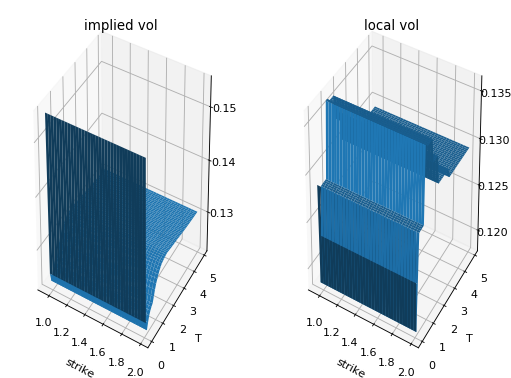

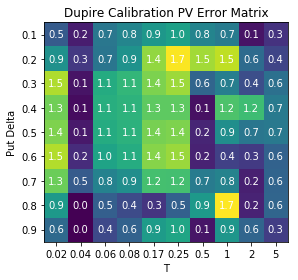

In [6]:
iv = createTestImpliedVol(S, r, q, sc = 0.0, smileInterpMethod='CUBICSPLINE')[0]
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a mild smile (tuned by the coeffiicent sc)

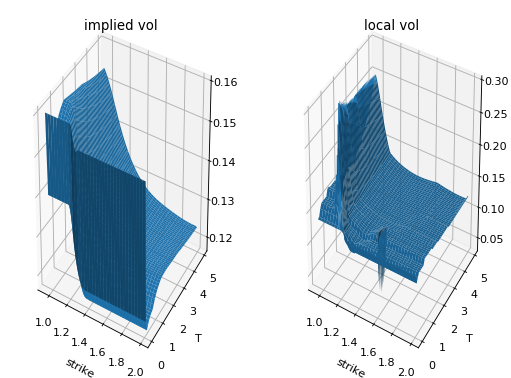

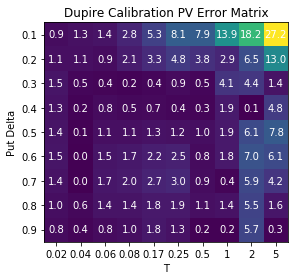

In [7]:
iv_1 = createTestImpliedVol(S, r, q, sc = 0.5, smileInterpMethod='CUBICSPLINE')[0]
plotTestImpliedVolSurface(iv_1)
pdeCalibReport(S, r, q, iv_1)

Then test smile case with CubicSpline, with a the input smile (sc = 1.0). It can be seen that the short end low strike region has some smile arbitrage. The calibration errors become larger.

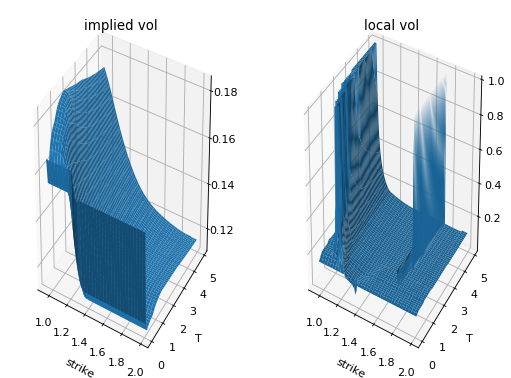

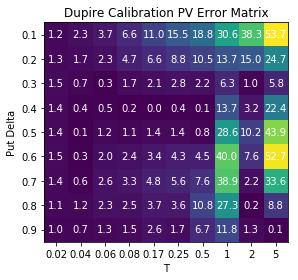

In [8]:
iv_2 = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='CUBICSPLINE')[0]
smiles_cubic = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='CUBICSPLINE')[1]
plotTestImpliedVolSurface(iv_2)
pdeCalibReport(S, r, q, iv_2)

***
### Your test cases with SmileAF

     pcost       dcost       gap    pres   dres
 0:  5.7202e-02 -1.1105e+03  4e+03  2e+01  1e+02
 1:  5.7900e-02 -1.7119e+02  3e+02  1e+00  7e+00
 2:  5.9520e-02 -2.2617e+01  2e+01  1e-02  7e-02
 3:  5.9530e-02 -5.2427e-01  6e-01  3e-04  1e-03
 4:  5.9479e-02 -1.0097e-01  2e-01  6e-05  3e-04
 5:  5.9001e-02  3.5717e-02  2e-02  8e-06  4e-05
 6:  5.8454e-02  5.5204e-02  3e-03  8e-07  5e-06
 7:  5.8141e-02  5.7587e-02  6e-04  1e-07  5e-07
 8:  5.8021e-02  5.7918e-02  1e-04  1e-08  7e-08
 9:  5.7987e-02  5.7976e-02  1e-05  1e-09  7e-09
10:  5.7982e-02  5.7982e-02  3e-07  2e-11  9e-11
11:  5.7982e-02  5.7982e-02  3e-09  2e-13  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.7441e-02 -7.1215e+02  3e+03  2e+01  9e+01
 1:  5.8101e-02 -1.1439e+02  2e+02  9e-01  5e+00
 2:  5.9526e-02 -1.3286e+01  1e+01  1e-02  5e-02
 3:  5.9483e-02 -4.7526e-01  5e-01  3e-04  2e-03
 4:  6.0201e-02 -1.2890e-01  2e-01  6e-05  3e-04
 5:  5.9996e-02  4.2835e-02  2e-02  5e-06  3e-0

 7:  8.2322e-02  8.0349e-02  2e-03  6e-07  1e-06
 8:  8.1944e-02  8.1144e-02  8e-04  4e-16  2e-15
 9:  8.1794e-02  8.1563e-02  2e-04  4e-16  2e-15
10:  8.1726e-02  8.1680e-02  5e-05  5e-16  1e-15
11:  8.1706e-02  8.1702e-02  4e-06  5e-16  1e-15
12:  8.1704e-02  8.1704e-02  7e-08  4e-16  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.7202e-02 -1.1105e+03  4e+03  2e+01  1e+02
 1:  5.7900e-02 -1.7119e+02  3e+02  1e+00  7e+00
 2:  5.9520e-02 -2.2617e+01  2e+01  1e-02  7e-02
 3:  5.9530e-02 -5.2427e-01  6e-01  3e-04  1e-03
 4:  5.9479e-02 -1.0097e-01  2e-01  6e-05  3e-04
 5:  5.9001e-02  3.5717e-02  2e-02  8e-06  4e-05
 6:  5.8454e-02  5.5204e-02  3e-03  8e-07  5e-06
 7:  5.8141e-02  5.7587e-02  6e-04  1e-07  5e-07
 8:  5.8021e-02  5.7918e-02  1e-04  1e-08  7e-08
 9:  5.7987e-02  5.7976e-02  1e-05  1e-09  7e-09
10:  5.7982e-02  5.7982e-02  3e-07  2e-11  9e-11
11:  5.7982e-02  5.7982e-02  3e-09  2e-13  1e-12
Optimal solution found.
     pcost       dcost

 6:  8.3041e-02  7.5879e-02  7e-03  9e-06  2e-05
 7:  8.2322e-02  8.0349e-02  2e-03  6e-07  1e-06
 8:  8.1944e-02  8.1144e-02  8e-04  4e-16  2e-15
 9:  8.1794e-02  8.1563e-02  2e-04  4e-16  2e-15
10:  8.1726e-02  8.1680e-02  5e-05  5e-16  1e-15
11:  8.1706e-02  8.1702e-02  4e-06  5e-16  1e-15
12:  8.1704e-02  8.1704e-02  7e-08  4e-16  2e-15
Optimal solution found.


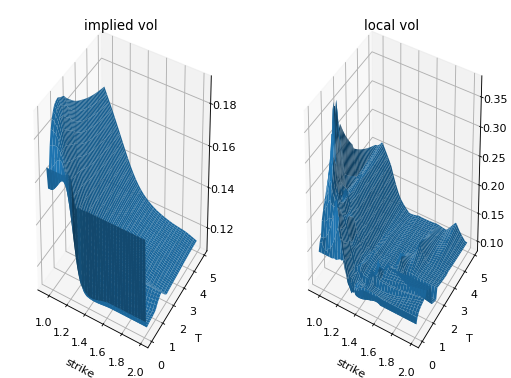

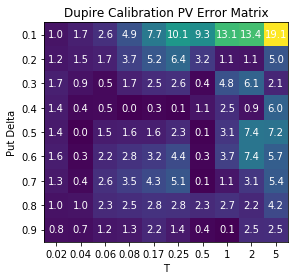

In [9]:
iv = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='AF')[0]
smiles = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='AF')[1]
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

     pcost       dcost       gap    pres   dres
 0:  5.6676e-02 -1.0525e+03  4e+03  2e+01  1e+02
 1:  5.7514e-02 -1.6883e+02  4e+02  2e+00  8e+00
 2:  5.9926e-02 -2.6884e+01  3e+01  2e-02  8e-02
 3:  5.9936e-02 -5.4858e-01  6e-01  3e-04  1e-03
 4:  5.9482e-02 -9.1056e-02  2e-01  6e-05  3e-04
 5:  5.8885e-02  3.7975e-02  2e-02  4e-06  2e-05
 6:  5.8191e-02  5.4944e-02  3e-03  5e-07  3e-06
 7:  5.7825e-02  5.7237e-02  6e-04  6e-08  3e-07
 8:  5.7692e-02  5.7574e-02  1e-04  9e-09  5e-08
 9:  5.7653e-02  5.7640e-02  1e-05  7e-10  4e-09
10:  5.7647e-02  5.7647e-02  3e-07  8e-12  4e-11
11:  5.7647e-02  5.7647e-02  1e-08  1e-13  5e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.6787e-02 -6.7332e+02  3e+03  2e+01  9e+01
 1:  5.7551e-02 -1.0935e+02  2e+02  1e+00  5e+00
 2:  5.9603e-02 -1.5922e+01  2e+01  1e-02  5e-02
 3:  5.9593e-02 -4.3190e-01  5e-01  3e-04  1e-03
 4:  5.9441e-02 -4.5019e-02  1e-01  3e-05  1e-04
 5:  5.8919e-02  4.4607e-02  1e-02  4e-06  2e-0

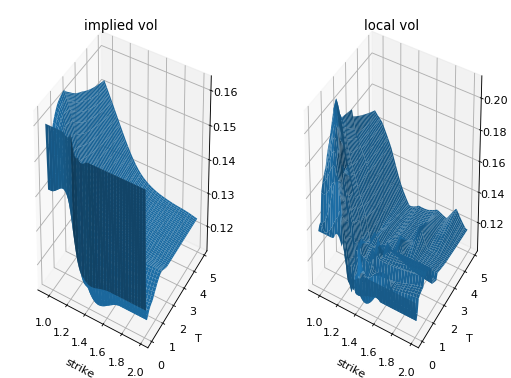

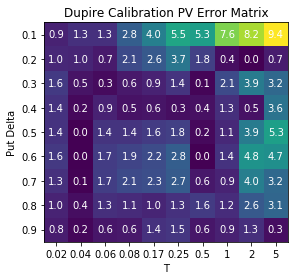

In [10]:
iv2 = createTestImpliedVol(S, r, q, sc = 0.5, smileInterpMethod='AF')[0]
plotTestImpliedVolSurface(iv2)
pdeCalibReport(S, r, q, iv2)

     pcost       dcost       gap    pres   dres
 0:  5.6180e-02 -9.8880e+02  4e+03  2e+01  1e+02
 1:  5.7211e-02 -1.7626e+02  4e+02  2e+00  1e+01
 2:  6.2572e-02 -4.0802e+01  4e+01  2e-02  1e-01
 3:  6.2563e-02 -7.8585e-01  9e-01  3e-04  2e-03
 4:  6.0483e-02 -1.3178e-01  2e-01  7e-05  3e-04
 5:  5.9876e-02  1.4704e-04  6e-02  5e-06  2e-05
 6:  5.8719e-02  4.7530e-02  1e-02  8e-07  4e-06
 7:  5.7941e-02  5.5377e-02  3e-03  1e-07  6e-07
 8:  5.7591e-02  5.6931e-02  7e-04  2e-08  7e-08
 9:  5.7468e-02  5.7312e-02  2e-04  3e-09  1e-08
10:  5.7429e-02  5.7419e-02  1e-05  2e-12  1e-11
11:  5.7426e-02  5.7425e-02  8e-07  3e-14  2e-13
12:  5.7426e-02  5.7426e-02  3e-08  7e-15  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.6282e-02 -6.2311e+02  3e+03  2e+01  9e+01
 1:  5.7224e-02 -1.0719e+02  2e+02  1e+00  6e+00
 2:  6.0326e-02 -2.1914e+01  2e+01  1e-02  6e-02
 3:  6.0335e-02 -4.6078e-01  5e-01  3e-04  1e-03
 4:  5.9826e-02 -4.8079e-02  1e-01  4e-05  2e-0

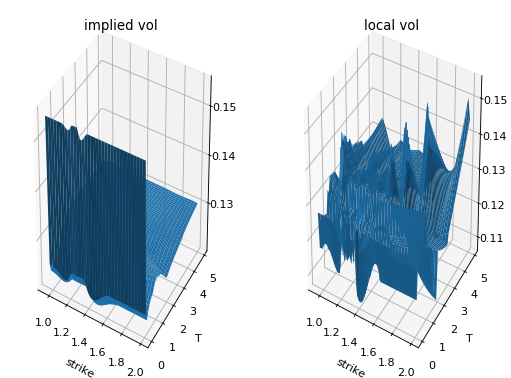

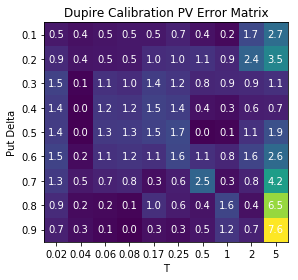

In [11]:
iv3 = createTestImpliedVol(S, r, q, sc = 0.0, smileInterpMethod='AF')[0]
plotTestImpliedVolSurface(iv3)
pdeCalibReport(S, r, q, iv3)

**Check for the correctness of the outputs of SmileAF ($sc = 1$)**

*Check for the smoothness of call prices  and inequality constraints*

In [12]:
import pandas as pd
pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5] 
atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]

In [13]:
dat = np.matrix(np.zeros((50,2*len(smiles))))
for i in range(len(smiles)):
    dat[:,2*i] = np.array(smiles[i].cs).reshape(len(smiles[i].cs),1)
    dat[:,2*i+1] = np.array(smiles[i].ps).reshape(len(smiles[i].ps),1)
pd.DataFrame(dat, columns = [["Undiscounted Call Price","p.d.f"]*len(smiles)])

,Undiscounted Call Price,p.d.f,Undiscounted Call Price,p.d.f,Undiscounted Call Price,p.d.f,Undiscounted Call Price,p.d.f,Undiscounted Call Price,p.d.f,...,Undiscounted Call Price,p.d.f,Undiscounted Call Price,p.d.f,Undiscounted Call Price,p.d.f,Undiscounted Call Price,p.d.f,Undiscounted Call Price,p.d.f
0,1.308937e-01,0.000000e+00,1.642984e-01,0.000000e+00,1.863547e-01,0.000000e+00,2.091639e-01,0.000000e+00,2.759838e-01,0.000000e+00,...,6.095324e-01,0.000000e+00,7.128999e-01,0.000000e+00,7.867673e-01,0.000000e+00,8.911688e-01,0.000000e+00,1.027925e+00,0.000000e+00
1,1.252548e-01,6.366994e-08,1.571119e-01,3.090171e-08,1.781183e-01,4.604215e-07,1.998165e-01,1.276458e-06,2.632192e-01,5.551925e-07,...,5.740282e-01,9.624173e-02,6.669574e-01,9.666735e-02,7.315833e-01,1.008529e-01,8.191676e-01,1.231201e-01,9.229966e-01,1.778037e-01
2,1.196158e-01,6.945550e-08,1.499254e-01,3.594909e-08,1.698819e-01,5.606411e-07,1.904692e-01,1.669031e-06,2.504546e-01,1.357483e-06,...,5.386307e-01,1.220931e-01,6.211960e-01,1.276805e-01,6.766725e-01,1.339013e-01,7.477288e-01,1.563787e-01,8.197599e-01,2.050441e-01
3,1.139768e-01,8.033716e-08,1.427388e-01,4.299707e-08,1.616455e-01,7.173769e-07,1.811218e-01,2.425168e-06,2.376900e-01,1.053962e-05,...,5.033912e-01,1.668134e-01,5.757108e-01,1.762635e-01,6.221795e-01,1.851654e-01,6.771237e-01,2.135497e-01,7.188694e-01,2.726179e-01
4,1.083378e-01,1.023411e-07,1.355523e-01,5.356036e-08,1.534090e-01,9.990794e-07,1.717745e-01,4.496844e-06,2.249261e-01,2.508965e-02,...,4.683612e-01,2.064487e-01,5.305965e-01,2.202214e-01,5.682489e-01,2.313710e-01,6.076240e-01,2.649329e-01,6.209793e-01,3.294217e-01
5,1.026989e-01,1.478930e-07,1.283658e-01,7.129637e-08,1.451726e-01,1.669096e-06,1.624271e-01,2.124443e-05,2.121694e-01,1.685324e-01,...,4.335920e-01,2.475551e-01,4.859481e-01,2.651100e-01,5.150251e-01,2.795949e-01,5.395012e-01,3.155547e-01,5.267440e-01,3.889720e-01
6,9.705989e-02,2.490192e-07,1.211793e-01,1.084007e-07,1.369362e-01,5.670932e-06,1.530798e-01,4.927176e-03,1.994394e-01,2.803978e-01,...,3.991351e-01,2.878619e-01,4.418604e-01,3.109009e-01,4.626529e-01,3.248042e-01,4.730268e-01,3.750100e-01,4.368177e-01,4.483061e-01
7,9.142091e-02,5.253212e-07,1.139928e-01,2.539085e-07,1.286998e-01,4.481748e-04,1.437366e-01,2.579865e-01,1.867553e-01,4.007456e-01,...,3.650418e-01,3.298959e-01,3.984283e-01,3.521520e-01,4.112768e-01,3.800535e-01,4.084722e-01,3.998925e-01,3.518182e-01,4.859866e-01
8,8.578194e-02,2.120864e-06,1.068063e-01,2.928324e-06,1.204668e-01,3.006908e-01,1.344152e-01,4.648204e-01,1.741364e-01,5.187394e-01,...,3.313635e-01,3.658211e-01,3.557466e-01,4.106601e-01,3.610412e-01,3.981572e-01,3.461092e-01,5.542329e-01,2.723580e-01,6.076486e-01
9,8.014296e-02,1.005389e-04,9.962255e-02,3.247679e-01,1.122541e-01,5.934861e-01,1.251346e-01,6.839314e-01,1.616021e-01,6.376674e-01,...,2.981517e-01,4.244541e-01,3.139104e-01,4.046800e-01,3.120909e-01,5.548035e-01,2.865255e-01,5.904458e-01,2.004072e-01,1.150263e+00


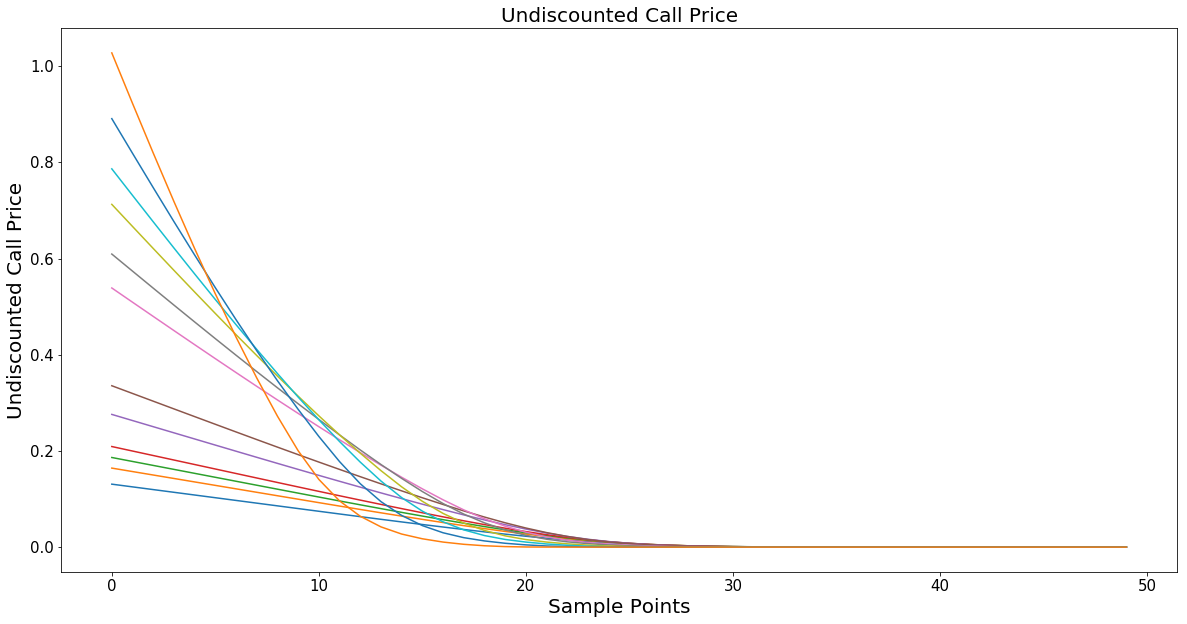

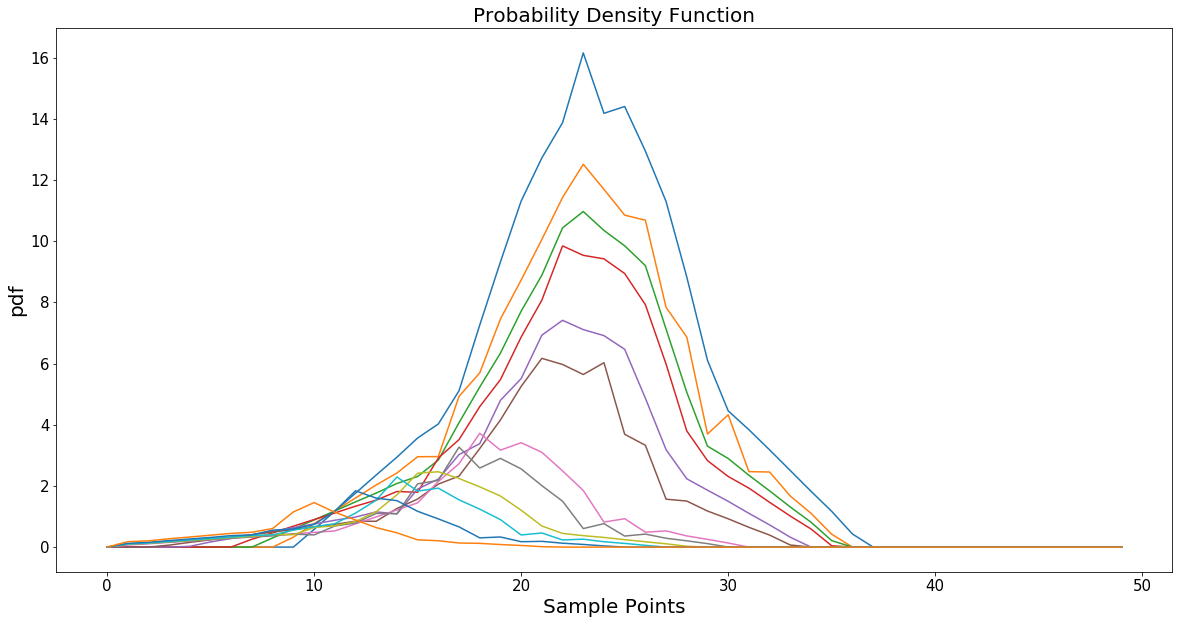

In [14]:
plt.figure(figsize=(20,10))
for i in range(len(smiles)):
    plt.plot(smiles[i].cs)
plt.xlabel("Sample Points",size = "20")
plt.ylabel("Undiscounted Call Price",size = "20")
plt.title("Undiscounted Call Price", size = "20")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

plt.figure(figsize=(20,10))
for i in range(len(smiles)):
    plt.plot(smiles[i].ps)
plt.xlabel("Sample Points",size = "20")
plt.ylabel("pdf",size = "20")
plt.title("Probability Density Function",size = "20")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

*Check for equality constraints*

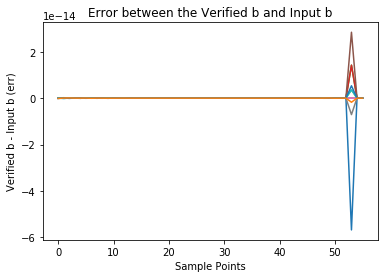

,"Verified b - Input b, pillar = 0.02","Verified b - Input b, pillar = 0.04","Verified b - Input b, pillar = 0.06","Verified b - Input b, pillar = 0.08","Verified b - Input b, pillar = 0.16","Verified b - Input b, pillar = 0.25","Verified b - Input b, pillar = 0.75","Verified b - Input b, pillar = 1.0","Verified b - Input b, pillar = 1.5","Verified b - Input b, pillar = 2","Verified b - Input b, pillar = 3","Verified b - Input b, pillar = 5"
0,-4.634446e-17,2.476130e-17,-3.811471e-17,5.010826e-17,5.225881e-17,2.741036e-17,-4.388656e-17,7.069533e-17,-3.992550e-17,2.428980e-17,-1.403942e-16,-1.571004e-16
1,4.403848e-17,-1.317615e-17,2.518041e-17,-3.810754e-17,-2.505689e-17,-3.687917e-17,6.303908e-17,-6.153684e-17,1.908024e-16,-1.720921e-16,8.276654e-17,2.833952e-17
2,-1.588692e-17,8.302491e-18,-3.199371e-17,3.663328e-17,-5.972036e-18,3.397828e-17,3.864678e-17,-5.064099e-17,-5.925248e-17,6.277205e-17,-1.060420e-16,7.312626e-17
3,4.202482e-18,-1.461857e-17,6.829779e-18,-1.527067e-17,9.769138e-18,-3.258554e-17,-4.466122e-18,1.024438e-16,7.773341e-17,-1.352543e-17,3.905521e-17,1.769773e-17
4,4.724964e-18,-2.360572e-17,7.482374e-18,1.023209e-17,2.629819e-17,2.189097e-17,-5.302684e-17,-5.923992e-17,-6.734848e-17,-7.822501e-17,8.955086e-18,-5.151419e-18
5,3.695047e-18,1.445552e-17,-5.593199e-17,5.222255e-18,-2.684099e-17,1.253544e-18,1.157276e-17,2.137556e-17,2.838233e-17,8.406501e-17,-5.759908e-17,3.860531e-17
6,-4.659347e-18,-1.103749e-18,7.916552e-18,1.738644e-17,4.620880e-17,-5.850711e-18,1.193554e-17,5.804517e-17,8.180173e-17,-1.307069e-17,-3.863254e-17,-6.146476e-17
7,4.050352e-18,1.500858e-17,-1.036764e-17,-1.228400e-17,-4.354169e-17,-1.004930e-17,-4.195674e-17,-6.285390e-17,-5.912158e-17,-6.494979e-18,4.161649e-17,2.386745e-17
8,3.071046e-18,-2.054969e-17,8.854261e-18,2.815123e-18,2.955675e-17,2.732491e-17,-5.630478e-17,1.192365e-17,5.887689e-17,2.300873e-17,2.207254e-17,-4.214864e-18
9,-1.659431e-17,2.282924e-17,-9.299967e-18,1.336563e-18,1.314371e-18,-2.265128e-17,5.436878e-17,4.315190e-17,4.104152e-17,2.176109e-17,-7.988333e-17,-1.705370e-17


In [15]:
# Check for Ax = b, the difference between the verified b and the input b used in optimal problem
b_err = np.matrix(np.zeros((len(smiles[0].b),len(smiles))))
for i in range(len(smiles)):
    x = np.matrix(np.concatenate((smiles[i].cs,smiles[i].ps[1:len(smiles[i].ps)-1]))).transpose()
    bVerified = np.dot(np.matrix(smiles[i].A),x)
    b_err[:,i] = (bVerified-np.array(smiles[i].b)).reshape(len(smiles[0].b),1)
    plt.plot(b_err[:,i])
plt.xlabel("Sample Points")
plt.ylabel("Verified b - Input b (err)")
plt.title("Error between the Verified b and Input b")
plt.show()
pd.DataFrame(b_err, columns = [['Verified b - Input b, pillar = '+str(pillar) for pillar in pillars]])

We verify the vector $b$ using the resulting $x$, i.e. $b_{\text{verified}} = Ax$, then compare $b_{\text{verified}}$ with the input $b$ used in the formulation of the optimal problem. From the chart given above, the differences between $b_{\text{verified}}$ and input $b$ are subtle. Therefore, it proves the correctness of our output vector $x = [c_1,c_2,\dots,c_N,p_2,p_3,\dots,p_{N-1}]$ since $Ax = b$ satisfies. 

*Check for the correctness of inputs*

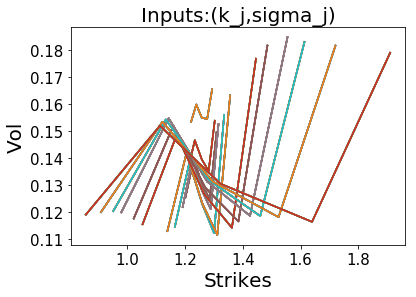

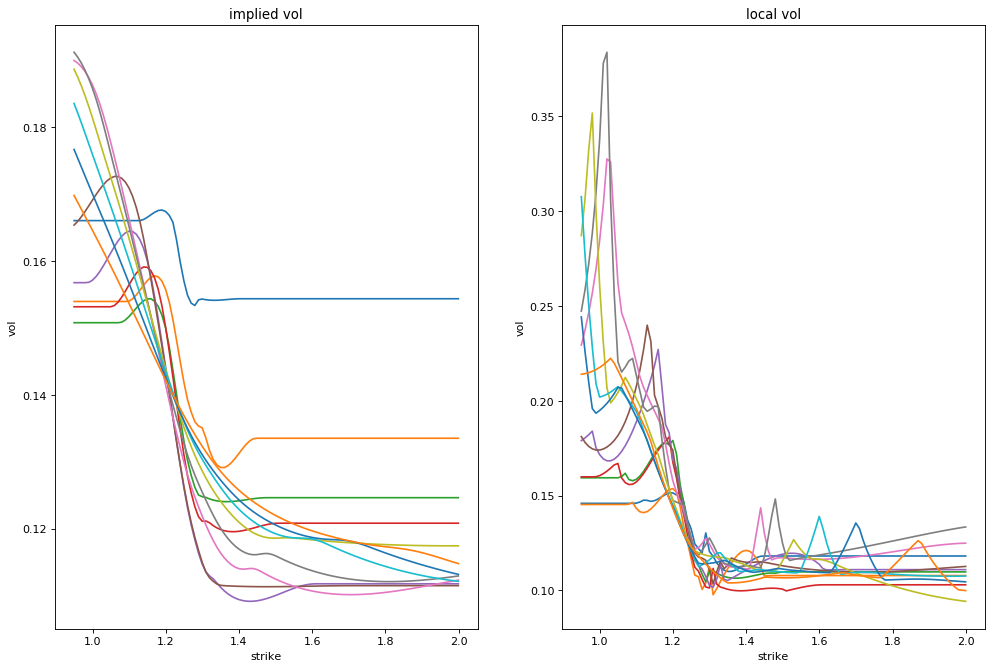

,"implied vol - input vol, pillar = 0.02","implied vol - input vol, pillar = 0.04","implied vol - input vol, pillar = 0.06","implied vol - input vol, pillar = 0.08","implied vol - input vol, pillar = 0.16","implied vol - input vol, pillar = 0.25","implied vol - input vol, pillar = 0.75","implied vol - input vol, pillar = 1.0","implied vol - input vol, pillar = 1.5","implied vol - input vol, pillar = 2","implied vol - input vol, pillar = 3","implied vol - input vol, pillar = 5"
c25,1.216801e-02,1.808558e-02,0.024135,3.068183e-02,0.041477,5.040317e-02,6.140065e-02,0.064070,0.064783,0.062880,6.149287e-02,0.060314
p25,3.317298e-07,4.381171e-07,-0.000010,-9.096527e-08,-0.000072,3.133554e-06,-1.130074e-07,-0.000386,0.000009,0.000007,9.665819e-07,0.000015
atmvol,7.970077e-05,-5.839775e-07,-0.000007,3.636519e-06,-0.000007,-1.031167e-07,1.303376e-04,0.000247,-0.000022,0.000167,3.429535e-05,-0.000016
c10,-1.106786e-03,5.724440e-04,0.000650,7.432621e-04,0.002348,1.721029e-03,1.298758e-03,0.001107,0.001247,0.001795,1.848843e-03,0.002655
p10,-1.115015e-02,-1.906410e-02,-0.024840,-3.153771e-02,-0.043942,-5.183021e-02,-6.291145e-02,-0.065491,-0.066234,-0.064844,-6.380015e-02,-0.062791


In [16]:
diff = np.matrix(np.zeros((5,len(pillars))))
for atmvol,bf25,rr25,bf10,rr10,T,i in zip(atmvols,bf25s,rr25s,bf10s,rr10s,pillars,range(len(pillars))):
    c25 = bf25 + atmvol + rr25/2
    p25 = bf25 + atmvol - rr25/2
    c10 = bf10 + atmvol + rr10/2
    p10 = bf10 + atmvol - rr10/2
    sigma_ori = [c25,p25,atmvol,c10,p10]
    ks = [strikeFromDelta(S, r, q, T, p10, 0.1, PayoffType.Put),
          strikeFromDelta(S, r, q, T, p25, 0.25, PayoffType.Put),
          S * math.exp((r-q)*T),
          strikeFromDelta(S, r, q, T, c25, 0.25, PayoffType.Call),
          strikeFromDelta(S, r, q, T, c10, 0.1, PayoffType.Call) ]
    for j in range(len(ks)):
        diff[j,i] = iv.Vol(T,ks[j])-sigma_ori[j]
        #diff.append(iv.Vol(T,ks[j])-sigma_ori[j])
    for i in range(len(pillars)):
        plt.plot(ks,sigma_ori)
plt.xlabel("Strikes",size = "20")
plt.ylabel("Vol",size = "20")
plt.title("Inputs:(k_j,sigma_j)",size = "20")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

#plot the implied volatility
plotTestImpliedVol(iv)
pd.DataFrame(diff, columns = [['implied vol - input vol, pillar = '+str(pillar) for pillar in pillars]],index = ["c25","p25","atmvol","c10","p10"])

The figure for input volatility shows a similar trend with the figures for implied volatility and local volatility after SmileAF interpolation. Meanwhile, the difference between input volatility and implied volatility after SmileAF interpolation is relatively small.

**Comparison of the price errors obtained from Cubic Spline Interpolation and Smile Arbitrage Free**

**First we consider when sc = 0, for both SmileAF (first matrix) and Cubic Spline (second matrix).**

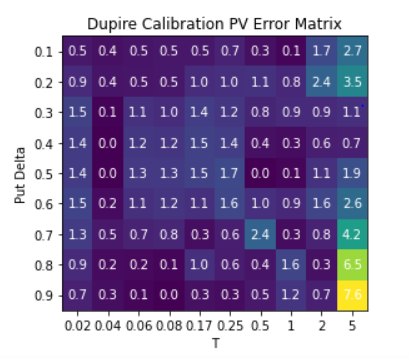
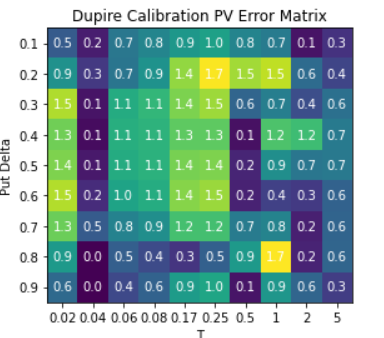 

**Generally, the price errors from both methods are similar for most pillars. One point to note is when T = 5, the AF method induces larger errors. This becomes extremely significant in high put delta values. It seems that both methods have the same performance.**

------------------------------------------------------------------------------------------------------------------------------
**Next, when sc = 0.5.**
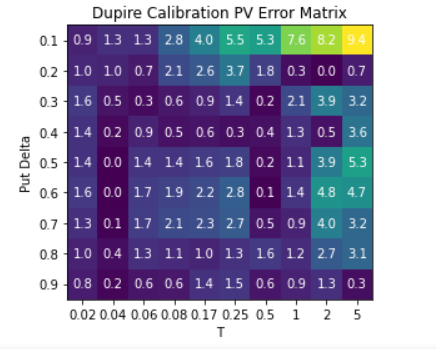
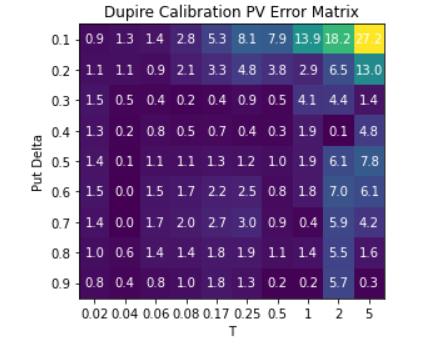

**In this case, in the middle portion of the matrix, both methods produces similar levels of pricing errors. However, the stark difference comes when the value of the put delta is low (0.1) as T increases. The Cubic Spline seriously underperforms as compared to the AF method. The error when T=5 and put delta = 0.1, is almost 3 times as much compared to the AF method.**

-------------------------------------------------------------------------------------------------------------------------------
**Lastly, when sc=1.**
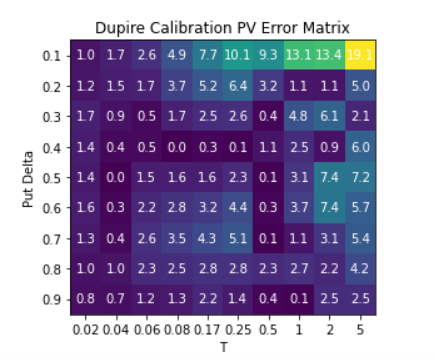
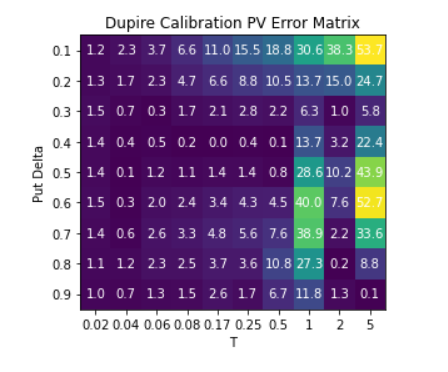

**Generally, the AF method produces less pricing errors compared to the cubic spline method. Interestingly, the error when T = 1, for all put delta values, the error computed from the cubic spline method skyrockets high as compared to the AF method. Also,  When T =5, it becomes extremely apparent that the pricing error induced by the cubic spline method is extremely high compared to the AF counterpart. This can be said for low values of put delta as well (0.1,0.2) when value of T increases. Therefore, it seems that the SmileAF produces relatively accurate results and should be preferred over the Cubic Spline method.**

**Improvements**

*Use kernel density function to find out the mean & variance of the resulting $p_i, i = 1,\dots,N$ from SmileAF with $sc = 1$.*

In [17]:
from sklearn.neighbors import kde
from scipy.integrate import quad
for i in range(len(smiles)):
    #X = np.array(smiles[i].ps)
    X = np.array(smiles[i].ps)[:, np.newaxis]#.reshape(-1,1)
    kde_ = kde.KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
    
    # Mean and Variance - Integration
    pdf = lambda x : np.exp(kde_.score_samples([[x]]))[0]
    mean_integration = quad(lambda x: x * pdf(x), a=-np.inf, b=np.inf)[0]
    variance_integration = quad(lambda x: (x ** 2) * pdf(x), a=-np.inf, b=np.inf)[0] - mean_integration ** 2
    
    # Mean and Variance - Monte Carlo
    n_samples = 10000000
    samples = kde_.sample(n_samples)
    
    mean_mc = samples.mean()
    variance_mc = samples.var()
    print('Mean:\nIntegration: {}\nMonte Carlo: {}\n'.format(mean_integration, mean_mc))
    print('Variance\nIntegration: {}\nMonte Carlo: {}\n'.format(variance_integration, variance_mc))
    
    print(kde_.score_samples(X))
    print(np.exp(kde_.score_samples(X)))

Mean:
Integration: 3.546743750144042
Monte Carlo: 3.5458175821949585

Variance
Integration: 24.10536613566265
Monte Carlo: 24.105896645670107

[-0.08100446 -0.08100446 -0.08100446 -0.08100446 -0.08100445 -0.08100445
 -0.08100445 -0.08100443 -0.08100434 -0.08099892 -2.46744156 -2.51326102
 -2.53182427 -2.61853423 -2.7493962  -2.73143518 -2.62610849 -3.21701851
 -3.22152357 -3.17594481 -2.52991058 -2.79230096 -2.92895339 -3.22152363
 -2.605805   -2.76881444 -2.79228759 -2.52991058 -3.17594481 -3.22151916
 -3.1142283  -2.50095366 -2.72041734 -2.59520476 -2.53013933 -2.51343228
 -1.81724857 -0.08100327 -0.08100434 -0.08100442 -0.08100444 -0.08100445
 -0.08100445 -0.08100445 -0.08100445 -0.08100446 -0.08100446 -0.08100446
 -0.08100446 -0.08100446]
[0.92218958 0.92218958 0.92218958 0.92218958 0.92218958 0.92218959
 0.92218959 0.92218961 0.92218969 0.92219468 0.08480154 0.08100365
 0.07951383 0.07290965 0.06396647 0.06512576 0.0723595  0.04007436
 0.03989423 0.04175464 0.07966614 0.06128005 0

Mean:
Integration: 0.5629930910297575
Monte Carlo: 0.5634476226685724

Variance
Integration: 0.7901894849900002
Monte Carlo: 0.790523235984866

[ 9.74575270e-02  1.31556518e-01  1.15026291e-01  6.45702128e-02
 -3.61109691e-04 -8.43907511e-02 -1.80190662e-01 -2.91207223e-01
 -3.93020268e-01 -5.68788756e-01 -4.89406590e-01 -1.34952151e+00
 -1.58409681e+00 -2.17300736e+00 -2.16090786e+00 -2.15172125e+00
 -2.17405067e+00 -3.05120005e+00 -2.32037068e+00 -2.69054117e+00
 -2.31931915e+00 -2.21626386e+00 -2.93942080e+00 -1.12466009e+00
 -1.53841603e+00 -3.77898922e-01 -5.69409910e-01 -1.82675123e-01
  2.36875367e-03  1.21794946e-01  9.86590909e-02  9.74580423e-02
  9.74576903e-02  9.74576415e-02  9.74576170e-02  9.74576022e-02
  9.74575923e-02  9.74575853e-02  9.74575801e-02  9.74575763e-02
  9.74575733e-02  9.74575712e-02  9.74575698e-02  9.74575690e-02
  9.74575689e-02  9.74575699e-02  9.74575726e-02  9.74575793e-02
  9.74576079e-02  9.74575270e-02]
[1.10236462 1.14060237 1.12190293 1.066700

*The improved SmileAF: with tail probability = 0.5%*

In [18]:
# np.random.seed(1)
# radnt = np.random.standard_t(1, 1000)
class SmileAF_Imp:
    def __init__(self, strikes, vols, T):
        self.atmvol = vols[int(len(vols)/2)]
        self.fwd = strikes[int(len(strikes)/2)]
        self.T = T
        self.N = 50 #number of sample points
        stdev = self.atmvol * math.sqrt(T)
        kmin = self.fwd * math.exp(-0.5*stdev*stdev-5 * stdev)
        kmax = self.fwd * math.exp(-0.5*stdev*stdev+5 * stdev)
        u = (kmax - kmin) / (self.N - 1)
        self.ks = [kmin + u * i for i in range(0, self.N)]
        self.cs = np.zeros(self.N)  # undiscounted call option prices
        self.ps = np.zeros(self.N)  # densities
        self.u = u
        
        # now we need to construct our constrained optimization problem to solve for cs and ps
        #Your code here to solve for self.cs and self.ps
        
        # Equality Constraints
        R = np.zeros((self.N-2,self.N-2))
        P = np.zeros((2*self.N-2,2*self.N-2)) 
        Q = np.zeros((self.N-2,self.N))
        for i in range(1,self.N-3):
            R[i,i] = 2/3*self.u**2
            R[i,i-1] = 1/6*self.u**2
            R[i,i+1] = 1/6*self.u**2
        R[0,0],R[self.N-3,self.N-3] = 2/3*self.u**2,2/3*self.u**2
        R[0,1],R[self.N-3,self.N-4] = 1/6*self.u**2,1/6*self.u**2
        for i in range(self.N-2):
            Q[i,i] = 1
            Q[i,i+1] = -2
            Q[i,i+2] = 1
        A1 = np.hstack((Q,-R))  #constraint 1
        indices = [bisect.bisect_left(self.ks, strike) for strike in strikes]
        A2 = np.zeros((len(strikes),2*self.N-2))
        for index,i in zip(indices,range(len(strikes))):
            a = (self.ks[index+1]-strikes[i])/self.u
            b = 1-a
            #constraint 2
            A2[i,index],A2[i,index+1] = a,b  
            A2[i,index+self.N-1],A2[i,index+self.N] = (a*a*a-a)*self.u**2/6,(b*b*b-b)*self.u**2/6
        A3 = np.concatenate((np.zeros(self.N),np.ones(self.N-2)),axis = 0)  #constraint 4
        #constraint 5
        A4 = np.zeros((2,2*self.N-2)) 
        A4[0,0],A4[1,self.N-1] = 1,1
        A = matrix(np.vstack((A1,A2,A3,A4)))
        b = matrix(np.concatenate((np.zeros(self.N-2),[bsPrice2(self.fwd, vol, self.T, strike, PayoffType.Call) for vol,strike in zip(vols,strikes)],[0.995/u],[self.fwd-kmin,0]),axis = 0)) #self.Price(strike) 
       
        #Inequality Constraints
        G1 = np.hstack((np.zeros((self.N-2,self.N)),-np.identity(self.N-2))) #constraint 3
        G2 = np.zeros((self.N-1,2*self.N-2))
        for i in range(self.N-1):
            G2[i,i],G2[i,i+1] = -1,1  #constraint 6
        G = matrix(np.vstack((G1,G2)))
        h = matrix(np.concatenate((np.ones(self.N-2)*(-1e-20),np.zeros(self.N-1))))
        
        # Standard form
        for i in range(self.N,2*self.N-2):
            for j in range(self.N,2*self.N-2):
                P[i,j] = 2*R[i-self.N,j-self.N]
        P = matrix(P)
        q = matrix(np.zeros(2*self.N-2)) 
        
        self.A = A
        self.b = b
        self.G = G
        self.H = h
        self.P = P
        self.q = q
        
        # Construct the QP, invoke solver
        sol = solvers.qp(P,q,G,h,A,b)
        # Extract optimal value and solution
        for i in range(self.N):
            self.cs[i] = sol['x'][i]
        for i in range(self.N-2):
            self.ps[i+1] = sol['x'][i+self.N] 
        def implyVol(k, prc, v): #root searcher
            stdev = v * math.sqrt(self.T)
            d1 = (math.log(self.fwd / k)) / stdev + 0.5 * stdev
            d2 = (math.log(self.fwd / k)) / stdev - 0.5 * stdev
            return self.fwd * cnorm(d1) - k * cnorm(d2) - prc
        khmin = bisect.bisect_left(self.ks, strikes[0])
        khmax = bisect.bisect_right(self.ks, strikes[len(strikes)-1])
        kks = [0] * ((khmax+1) - (khmin-1) + 2)
        vs = [0] * ((khmax+1) - (khmin-1) + 2)
        for i in range(khmin-1, khmax+1):
            prc = self.Price(self.ks[i])
            f = lambda v: implyVol(self.ks[i], prc, v)
            a, b = 1e-8, 10
            vs[i - (khmin-1) + 1] = optimize.brentq(f, a, b) #bisectalgorithm(f,a,b,1e-6)  #root search
            kks[i - (khmin-1) + 1] = self.ks[i]
        kks[0] = kmin
        vs[0] = vs[1]
        kks[len(kks)-1] = kmax
        vs[len(vs)-1] = vs[len(vs)-2]

        self.vs = vs
        self.cubicVol = CubicSpline(kks, vs, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

    def Vol(self, k):
        if k < self.ks[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vs[0]
        if k > self.ks[-1]:
            return self.vs[-1]
        else:
            return self.cubicVol(k)

    # undiscounted call price - given cs and ps,
    # we can obtain undiscounted call price for any k via cubic spline interpolation
    def Price(self, k):
        if k <= self.ks[0]:
            return self.fwd - k
        if k >= self.ks[self.N-1]:
            return 0.0
        pos = bisect.bisect_left(self.ks, k)
        a = (self.ks[pos] - k) / self.u
        b = 1 - a
        c = (a * a * a - a) * self.u * self.u / 6.0
        d = (b * b * b - b) * self.u * self.u / 6.0
        return a * self.cs[pos-1] + b * self.cs[pos] + c*self.ps[pos-1] + d*self.ps[pos]

     pcost       dcost       gap    pres   dres
 0:  5.7281e-02 -1.0947e+03  4e+03  2e+01  1e+02
 1:  5.8093e-02 -1.5927e+02  4e+02  1e+00  8e+00
 2:  6.0668e-02 -2.9433e+01  3e+01  1e-02  8e-02
 3:  6.0692e-02 -4.5189e-01  5e-01  2e-04  9e-04
 4:  6.0248e-02  1.3127e-02  5e-02  2e-05  8e-05
 5:  5.9185e-02  5.1645e-02  8e-03  1e-06  7e-06
 6:  5.8670e-02  5.7447e-02  1e-03  2e-07  9e-07
 7:  5.8464e-02  5.8260e-02  2e-04  2e-08  1e-07
 8:  5.8402e-02  5.8390e-02  1e-05  6e-15  3e-14
 9:  5.8398e-02  5.8397e-02  3e-07  5e-15  4e-14
10:  5.8398e-02  5.8398e-02  3e-09  8e-15  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.7520e-02 -7.0211e+02  3e+03  2e+01  9e+01
 1:  5.8261e-02 -1.1544e+02  3e+02  1e+00  7e+00
 2:  6.0706e-02 -2.2928e+01  3e+01  4e-02  2e-01
 3:  6.0864e-02 -6.8117e-01  8e-01  6e-04  3e-03
 4:  6.0162e-02  1.4645e-02  5e-02  3e-05  2e-04
 5:  5.9428e-02  5.0971e-02  8e-03  5e-06  2e-05
 6:  5.8934e-02  5.7266e-02  2e-03  8e-07  4e-0

 6:  5.8670e-02  5.7447e-02  1e-03  2e-07  9e-07
 7:  5.8464e-02  5.8260e-02  2e-04  2e-08  1e-07
 8:  5.8402e-02  5.8390e-02  1e-05  6e-15  3e-14
 9:  5.8398e-02  5.8397e-02  3e-07  5e-15  4e-14
10:  5.8398e-02  5.8398e-02  3e-09  8e-15  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.7520e-02 -7.0211e+02  3e+03  2e+01  9e+01
 1:  5.8261e-02 -1.1544e+02  3e+02  1e+00  7e+00
 2:  6.0706e-02 -2.2928e+01  3e+01  4e-02  2e-01
 3:  6.0864e-02 -6.8117e-01  8e-01  6e-04  3e-03
 4:  6.0162e-02  1.4645e-02  5e-02  3e-05  2e-04
 5:  5.9428e-02  5.0971e-02  8e-03  5e-06  2e-05
 6:  5.8934e-02  5.7266e-02  2e-03  8e-07  4e-06
 7:  5.8709e-02  5.8433e-02  3e-04  9e-08  4e-07
 8:  5.8636e-02  5.8602e-02  3e-05  6e-09  3e-08
 9:  5.8622e-02  5.8621e-02  1e-06  5e-15  3e-14
10:  5.8621e-02  5.8621e-02  1e-08  8e-15  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.8291e-02 -5.6621e+02  2e+03  2e+01  8e+01
 1:  5.8852e-02 -1.0172

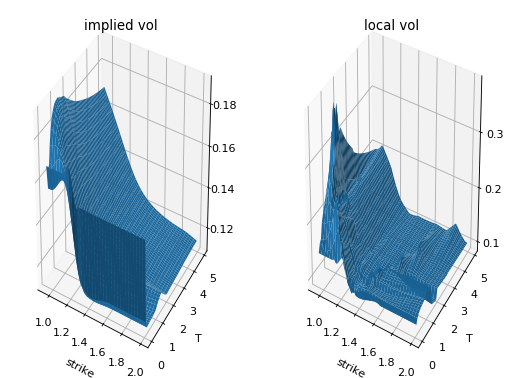

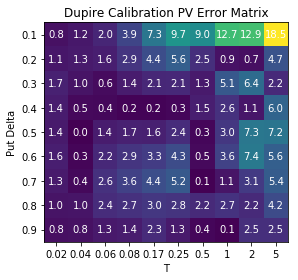

In [19]:
iv_imp = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='AF_Imp')[0]
smiles_imp = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='AF_Imp')[1]
plotTestImpliedVolSurface(iv_imp)
pdeCalibReport(S, r, q, iv_imp)

**First, since we are dealing with undiscounted call prices, we use "bsPrice2" function instead. The only difference between "bsPrice" and "bsPrice2" is the removal of the discounting factor. Also, in the function "createTestImpliedVol", we return an additional output "smiles" for each pillar. We attempted to improve the tails of the model using a Gaussian kernal distribution function. We changed 1/u to 0.995/u (Please see Function: SmileAF_Imp shown above). The results that we achieved show a relatively lower error (the PV error drops from 19.1 to 18.5 when Put Delta = 0.1 and T = 5) but generally represent no significant improvement.**



**However, as commented and suggested by Prof, calibration of several parameters is required to ensure that the performance of such a representation is good. This includes a parameter that dictates how fast the tails "flatten". Generally, the process is relatively complicated. Due to time constraints and limited knowledge in above procedure, we are unable to produce concrete improvements using a kernal distribution. However, we still believe that with the right approach and calibration of parameters, we should be able to represent the tails better using a kernal distribution. As such, we propose this improvement up for consideration and further work can be directed in this direction to further improve the results.**

### <u>**Discussion of potential interpolation improvements** </u>

We mainly take reference to **"Arbitrage-free Call Option Surface Construction using Regression Splines"** by **Orosi (2015)** in our discussion for further improvements to our interpolation method in the construction in the Abitrage Free Volatility Surface.

As indicated by the procedure above in this project, a cubic spline is used to interpolate the IVS, implied volalility surface. However, Homescu (2011) points out that a major disadvantage is that the resulting volatility surface could not be well defined to be arbitrage-free. Hence, it is recommended by Orosi (2010) that it is advantageous to consider a **non-parametric spline-based representation** instead.


Similarly, to guarantee an arbitrage-free surface, several conditions have to be met as followed:

+ **$C(K,T)$** is a decreasing convex function of the strike.
+ The construction of a calendar spread and no arbitrage arguments states that: **$C(K,T_2) > C(K,T_1)$**. 
+ **$-e^{rT}\leq \frac{\partial C(K,T)}{\partial K} \leq 0$**

Instead of the use of a cubic spline, regression spline smoothing allows for a true curve that is assumed to be recovered from the following:

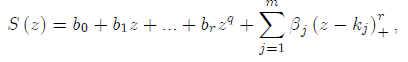

where, $r$ is the order of the regression spline, $\ k_j$ is the j-th knot and $β$ = $[b_0, \ldots , b_r, β_1, \ldots, β_q]^T$ is the set of coefficients. 

To determine $β$, employ quadratic programming to embed the shape-constraints instead of OLS.

-------------------------------------------------------------------------------------------------------------------------------

Instead of working in the call option space, Orosi proposed to smooth the call option functions by fitting a function described in **Orosi (2011)**. This approach guarantees the current price of a call option, with strike = 0 to be, $S_0$.

The **calibration of parameters** is then solved in the following procedure:

__**Minimise**__: 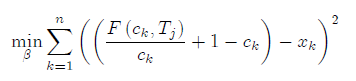

where $β$ is the parameter vector of the regression spline model, subject to the following constraints:

__**Constraint 1:**__
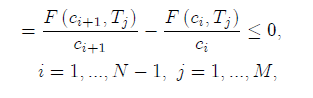

__**Constraint 2:**__
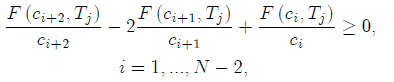

__**Constraint 3:**__
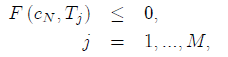

__**Constraint 4:**__
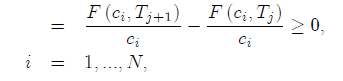

Then, apply the tranformation:
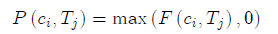


Splice knot placement is crucial; they chose to generate data points such that:
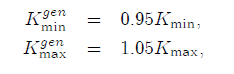
where, $K_{min}$ and $K_{max}$ are the smallest and largest strike prices at a given expiry time.
It is decided that the order of the regression spline is equal to **4**, and generate **50 uniformly distributed data points**.
Model evaluation is then proceeded by means of cross-validation.